# Analysis of ATLAS-GAN results

Let's take a look at the results of the DCGAN trained to generate ATLAS RPV SUSY events.

In [1]:
from __future__ import print_function

import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

import torch
from torch.autograd import Variable

from pyjet import cluster, DTYPE_PTEPM

%matplotlib notebook

In [2]:
def generate_samples(generator, n, noise_dim=64):
    # Generate input noise
    noise = Variable(torch.FloatTensor(n, noise_dim, 1, 1)
                 .normal_(0, 1))
    # Generate new samples
    samples = generator(noise)
    return samples.data.numpy().squeeze(1)

def correct_samples(x, thresh=0.00008):
    x = x.copy()
    x[x < thresh] = 0
    return x

def draw_image(x, vmin=None, vmax=None, xlabel='$\eta$', ylabel='$\phi$',
               draw_cbar=True, ax=None, figsize=(5,4), **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    cax = ax.imshow(x.T, extent=[-2.5, 2.5, -3.15, 3.15],
                    norm=LogNorm(vmin, vmax), aspect='auto',
                    origin='lower', **kwargs)
    if draw_cbar:
        cbar = plt.gcf().colorbar(cax, ax=ax)
        cbar.set_label('Normalized Energy')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

In [3]:
def build_jets(image):
    """Apply FastJet (via pyjet) to the image and return a list of PseudoJets"""
    eta_min, eta_max = -2.5, 2.5
    extent = eta_min, eta_max, -np.pi, np.pi
    bins = 64
    eta_edges = np.linspace(eta_min, eta_max, bins + 1)
    phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
    eta = np.linspace(eta_min, eta_max, bins + 1)[:-1] + (eta_max - eta_min) / (2 * bins)
    phi = np.linspace(-np.pi, np.pi, bins + 1)[:-1] + (np.pi / bins)
    X, Y = np.meshgrid(eta, phi)
        
    clusters = np.zeros(eta.shape[0] * phi.shape[0], dtype=DTYPE_PTEPM)
    E = image.T
    clusters['pT'] = E.ravel()
    clusters['eta'] = X.ravel()
    clusters['phi'] = Y.ravel()
    clusters['pT']=6072947*clusters['pT']/np.cosh(clusters['eta'])
    event = clusters[clusters['pT']>100]
    sequence = cluster(event, R=1.0, p=-1)
    jets = sequence.inclusive_jets(ptmin=200000)
    jets = [jet for jet in jets if (abs(jet.eta) < 2.0)]
    return jets

def build_jets_dataframe(event, jets):
    """Given a list of PseudoJets, convert into a Pandas dataframe"""
    jpt = np.array([j.pt for j in jets])
    jeta = np.array([j.eta for j in jets])
    jphi = np.array([j.phi for j in jets])
    jm = np.array([j.mass for j in jets])
    return pd.DataFrame(data=dict(event=event, pt=jpt, eta=jeta, phi=jphi, m=jm))

def reconstruct_events(samples):
    """Apply jet reconstruction on all samples and return a Pandas dataframe"""
    return pd.concat([build_jets_dataframe(i, build_jets(samples[i]))
                      for i in range(samples.shape[0])])

def draw_reco(sample):
    """Apply reconstruction to one sample and visualize the clusters"""
    jets = build_jets(sample)
    
    # Draw the provided jet image on the left
    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    draw_image(sample, vmin=1e-4, ax=axs[0], draw_cbar=False)

    # Draw the jets on the right
    for j in jets:
        s = axs[1].scatter(j.eta, j.phi, s=200, marker='+')
        cl = j.constituents_array()
        axs[1].scatter(cl['eta'], cl['phi'], s=5, marker=',', c=s.get_edgecolor())
        axs[1].set_xlim((-2.5, 2.5))
        axs[1].set_ylim((-np.pi, np.pi))
        axs[1].set_xlabel('$\eta$')
        axs[1].set_ylabel('$\phi$')

    plt.tight_layout()

## Load training results

In [4]:
results_dir = '/bigdata/shared/atlas_rpv/AtlasDCGAN_000'

In [6]:
# Load the generator
generator = torch.load(os.path.join(results_dir, 'generator.torch'))
generator.cpu().eval()

Generator(
  (network): Sequential(
    (0): ConvTranspose2d (64, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d (64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d (32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d (16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Sigmoid()
  )
)

In [7]:
# Load the training data
train_samples = np.load('/bigdata/shared/atlas_rpv/signal_caloimages.npy', mmap_mode='r')

# Load the result arrays
dis_losses = np.load(os.path.join(results_dir, 'dis_losses.npy'))
gen_losses = np.load(os.path.join(results_dir, 'gen_losses.npy'))
dis_outputs_real = np.load(os.path.join(results_dir, 'dis_outputs_real.npy'))
dis_outputs_fake = np.load(os.path.join(results_dir, 'dis_outputs_fake.npy'))
gen_train_samples = np.load(os.path.join(results_dir, 'gen_samples.npy'))

# Correct the generated training samples
gen_train_samples = correct_samples(gen_train_samples)

<IPython.core.display.Javascript object>


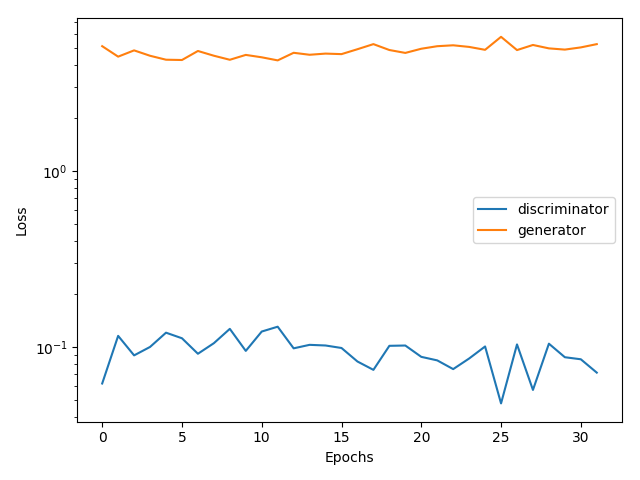

In [9]:
# Plot training loss
plt.figure()
plt.semilogy(dis_losses, label='discriminator')
plt.semilogy(gen_losses, label='generator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.tight_layout()

<IPython.core.display.Javascript object>


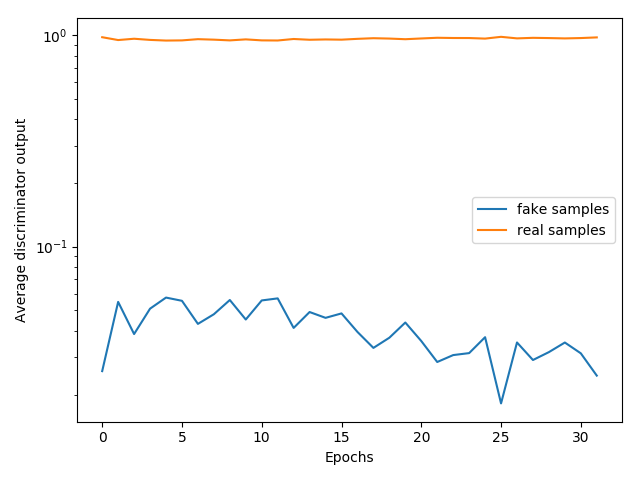

In [12]:
# Plot the discriminator average outputs per epoch
plt.figure()
plt.semilogy(dis_outputs_fake, label='fake samples')
plt.semilogy(dis_outputs_real, label='real samples')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Average discriminator output')
plt.tight_layout()

## Draw generated training samples from select epochs

epoch 0


<IPython.core.display.Javascript object>


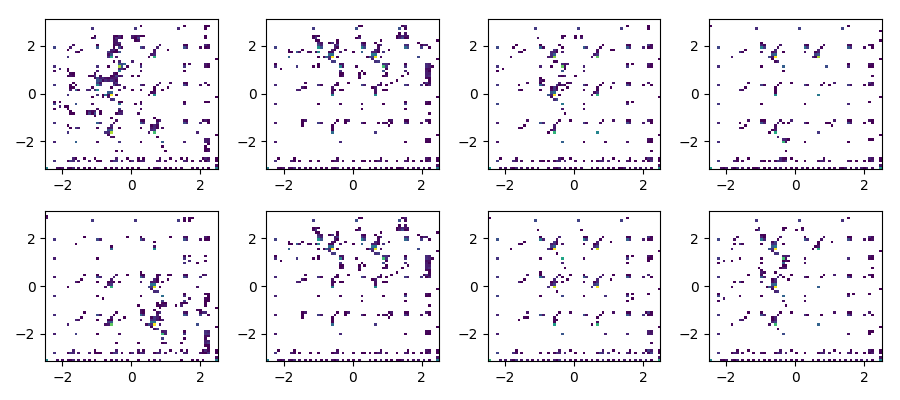

epoch 1


<IPython.core.display.Javascript object>


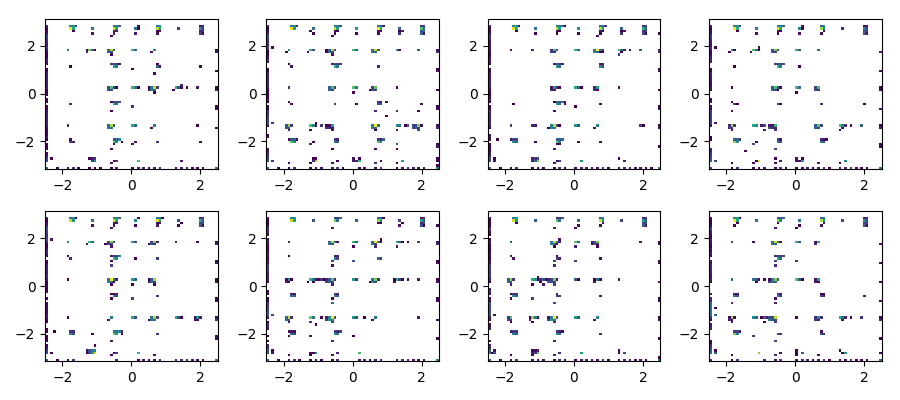

epoch 2


<IPython.core.display.Javascript object>


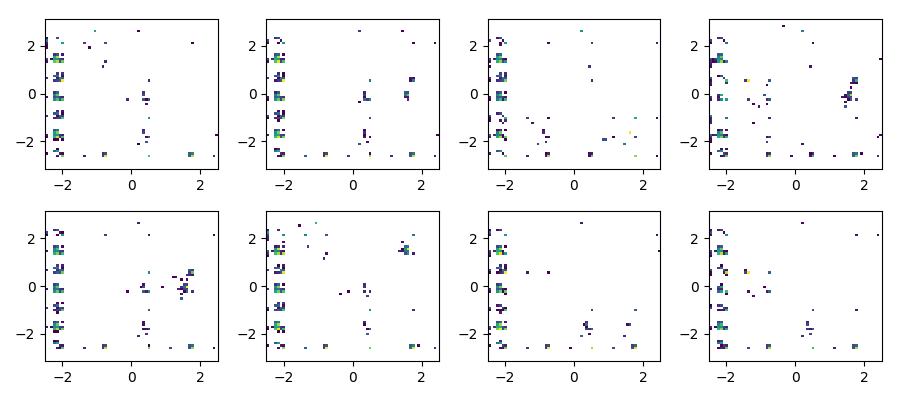

epoch 7


<IPython.core.display.Javascript object>


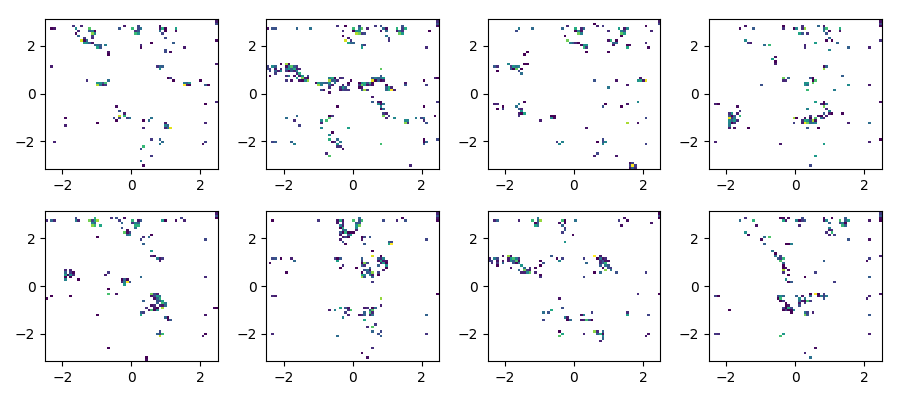

epoch 15


<IPython.core.display.Javascript object>


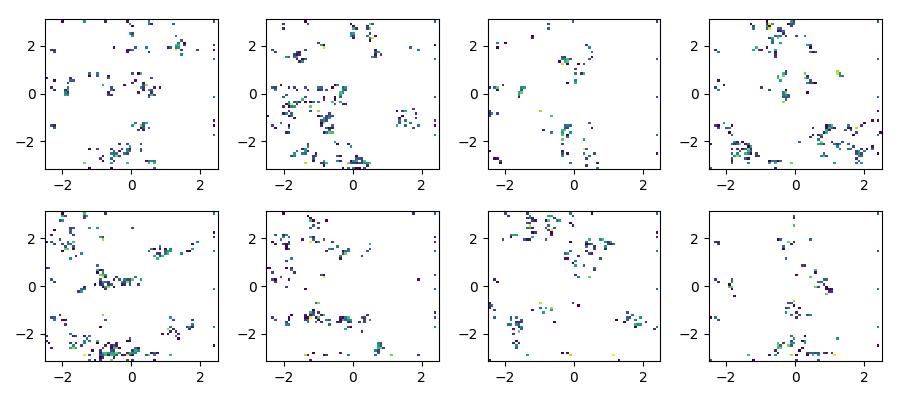

epoch 31


<IPython.core.display.Javascript object>


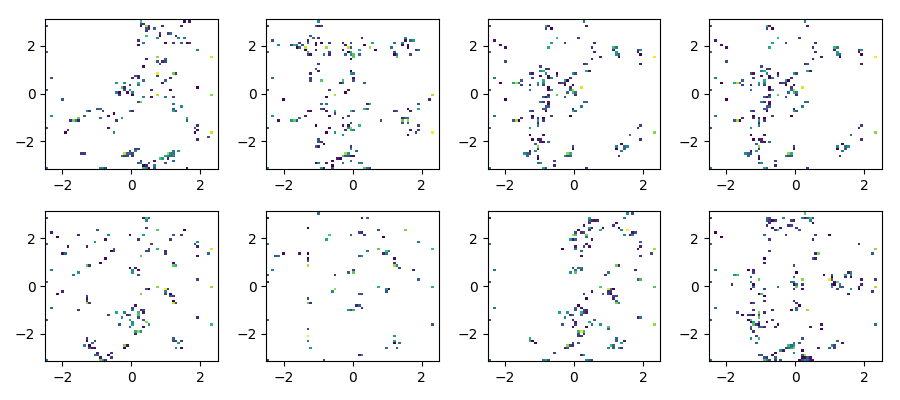

In [13]:
# Draw some samples from selected epoch
epochs = [0, 1, 2, 7, 15, 31]
for epoch in epochs:
    print('epoch', epoch)
    fig, axs = plt.subplots(2, 4, figsize=(9,4))
    for i, ax in enumerate(axs.flatten()):
        draw_image(gen_train_samples[epoch, i], vmin=1e-4, ax=ax,
                   draw_cbar=False, xlabel=None, ylabel=None)
    plt.tight_layout()

## Generate new samples

In [101]:
%%time
n_gen = 10000
gen_samples = correct_samples(generate_samples(generator, n_gen))

CPU times: user 54.8 s, sys: 1.55 s, total: 56.3 s
Wall time: 5.44 s


## Visualize generated and training samples

<IPython.core.display.Javascript object>


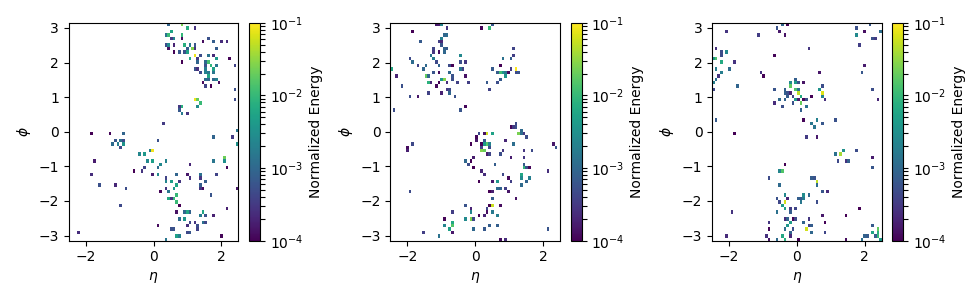

In [120]:
# Draw some real training samples
fig, axs = plt.subplots(1, 3, figsize=(9.8, 3))
for (i, ax) in enumerate(axs):
    draw_image(train_samples[i], ax=ax, vmin=1e-4, vmax=0.1)
plt.tight_layout()

<IPython.core.display.Javascript object>


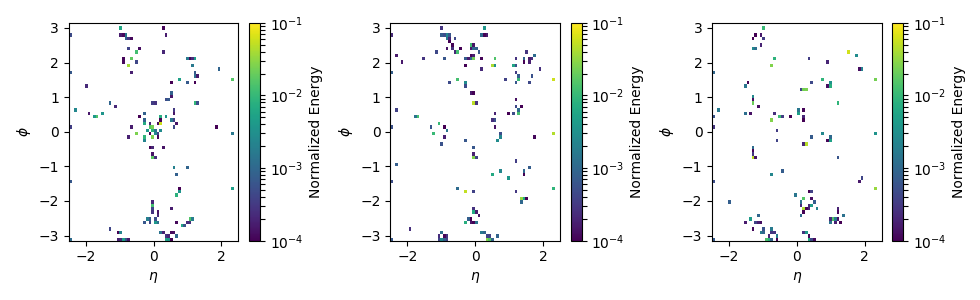

In [121]:
# Draw some generated samples
fig, axs = plt.subplots(1, 3, figsize=(9.8, 3))
for (i, ax) in enumerate(axs):
    draw_image(gen_samples[i], ax=ax, vmin=1e-4, vmax=0.1)
plt.tight_layout()

## Reconstruct jets from generated samples

In [104]:
%%time
gen_jets = reconstruct_events(gen_samples)

CPU times: user 14.5 s, sys: 40 ms, total: 14.5 s
Wall time: 14.5 s


<IPython.core.display.Javascript object>


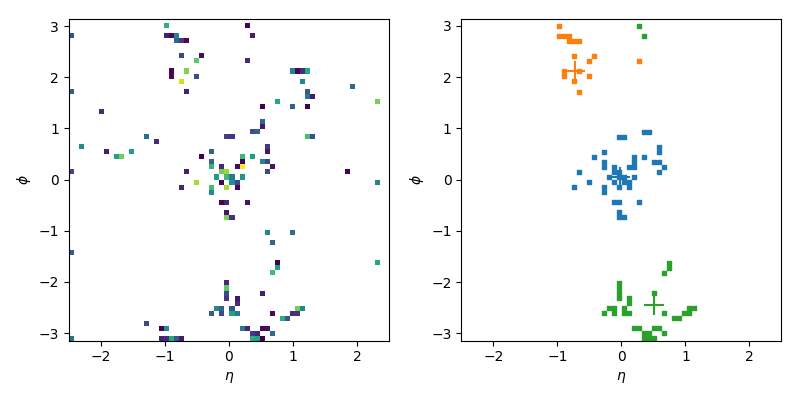

In [105]:
draw_reco(gen_samples[0])

## Reconstruct the training set images

In [122]:
%%time
n_train = 10000
train_jets = reconstruct_events(train_samples[-n_train:])

CPU times: user 16.1 s, sys: 76 ms, total: 16.2 s
Wall time: 16.2 s


<IPython.core.display.Javascript object>


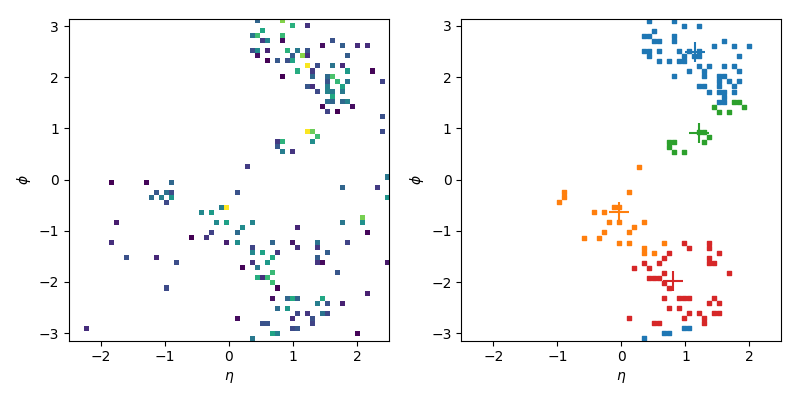

In [123]:
draw_reco(train_samples[0])

## Compare distributions

Now let's compare some reconstructed jet distributions between the training sample and the generated sample

<IPython.core.display.Javascript object>


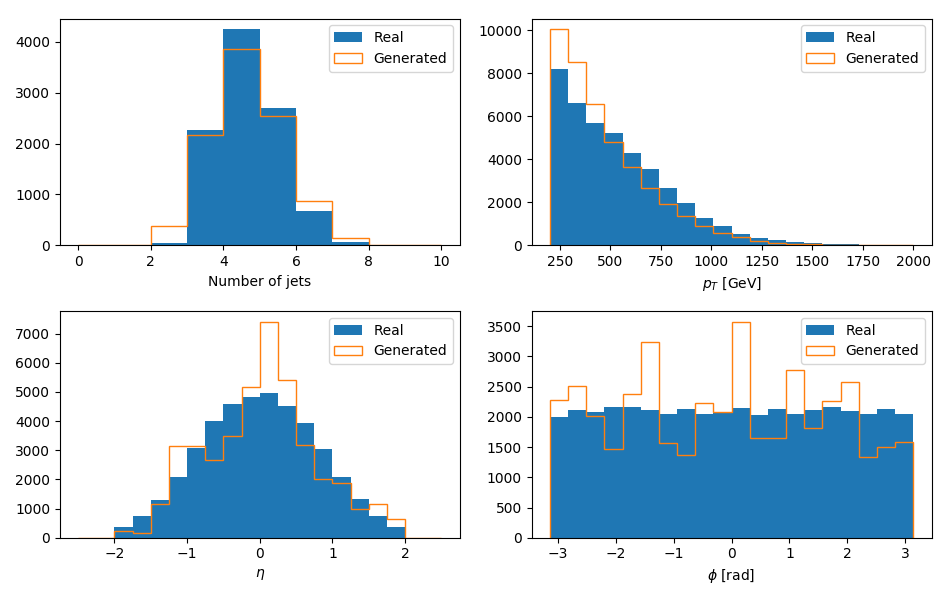

In [126]:
plt.figure(figsize=(9.5, 6))

# Jet multiplicity
plt.subplot(221)
train_nJet = train_jets.groupby('event').size()
gen_nJet = gen_jets.groupby('event').size()
binning = dict(bins=10, range=(0,10))
plt.hist(train_nJet, histtype='bar', label='Real', **binning)
plt.hist(gen_nJet, histtype='step', label='Generated', **binning)
plt.xlabel('Number of jets')
plt.legend(loc=0)

# Jet PT spectrum
plt.subplot(222)
binning = dict(bins=20, range=(200, 2000))
plt.hist(train_jets.pt * 1e-3, histtype='bar', label='Real', **binning)
plt.hist(gen_jets.pt * 1e-3, histtype='step', label='Generated', **binning)
plt.xlabel('$p_T$ [GeV]')
plt.legend(loc=0)

# Jet eta
plt.subplot(223)
binning = dict(bins=20, range=(-2.5, 2.5))
plt.hist(train_jets.eta, histtype='bar', label='Real', **binning)
plt.hist(gen_jets.eta, histtype='step', label='Generated', **binning)
plt.xlabel('$\eta$')
plt.legend(loc=0)

# Jet phi
plt.subplot(224)
binning = dict(bins=20, range=(-np.pi, np.pi))
plt.hist(train_jets.phi, histtype='bar', label='Real', **binning)
plt.hist(gen_jets.phi, histtype='step', label='Generated', **binning)
plt.xlabel('$\phi$ [rad]')
plt.legend(loc=0)

plt.tight_layout()

<IPython.core.display.Javascript object>


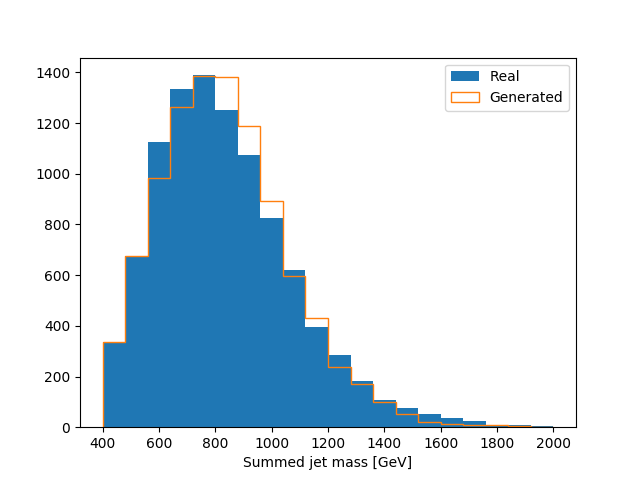

In [127]:
# Summed jet mass
train_sumMass = train_jets.groupby('event').apply(lambda x: x.m.sum())
gen_sumMass = gen_jets.groupby('event').apply(lambda x: x.m.sum())

plt.figure()
binning = dict(bins=20, range=(400, 2000))
plt.hist(train_sumMass*1e-3, histtype='bar', label='Real', **binning)
plt.hist(gen_sumMass*1e-3, histtype='step', label='Generated', **binning)
plt.xlabel('Summed jet mass [GeV]')
plt.legend(loc=0);

## Discussion

The GAN is seemingly able to produce semi-realistic calo images after training for 32 epochs.
We compare the physics by running FastJet reconstruction on the images, and we see that the
generated samples produce jet kinematics that roughly resemble those in the training set.
There are some notable issues here: the generated sample jets are too soft and central, and the sum jet mass is shifted upwards somewhat.